In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-010-25-adv-attack-llm/"
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

In [17]:
vectorstore = Chroma.from_documents(
    documents = doc_splits,
    collection_name = "rag-chroma",
    embedding = OpenAIEmbeddings(),
)

In [19]:
retriever = vectorestore.as_retriever()

In [27]:
question = "What is few-shot learning?"

docs = retriever.invoke(question)
# previously get_relevant_documents instead of invoke

for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


In [39]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class GradeDocuments(BaseModel):
    """
    Binary score for relevance check on retrieved documents
    """

    binary_score: str = Field(
        description = "Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(model = "gpt-4o-mini", temperature=0)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
    You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binaary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

for doc in docs:
    doc_txt = doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}), doc_txt[:50], '...', doc.metadata['source'])

binary_score='yes' Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='yes' Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='yes' Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/
binary_score='yes' Zero-shot and few-shot learning are two most basic ... https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/


### Generate Components

In [44]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print('------')

/Users/priyanuj/.local/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
------


In [56]:
llm = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Few-shot learning involves providing a model with a set of high-quality demonstrations that include both input and desired output for a specific task. This approach helps the model better understand human intentions and improves performance compared to zero-shot learning. However, it requires more tokens and may reach context length limits with longer texts.


### Question Re-Writer

In [59]:
three_five_llm = ChatOpenAI(model = "gpt-3.5-turbo", temperature = 0)

system = """
    You are a question re-writer that converts an input question to a better version that is optimized \n
    for web search. Look at the input and try to reason about the underlying semantic intent/ meaning.
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.")
        
    ]
)

question_rewriter = re_write_prompt | three_five_llm | StrOutputParser()

question, question_rewriter.invoke({"question": question})

('What is few-shot learning?',
 'What does few-shot learning refer to in machine learning?')

## Building the Graph

In [74]:
!pip install --upgrade typing_extensions

In [78]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        times_transformed: number of times the question has been re-written
    """

    question: str
    generation: str
    documents: [str]
    times_transformed: int

In [98]:
from langchain.schema import Document

def retrieve(state):
    print(state)

    """
    Retrieve documents

    Args:
        state (dict) : The current graph state

    Returns:
        state(dict) : New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "times_transformed": 0}


def generate(state):
    """
    Generate answer

    Args:
        state(dict): The current graph state

    Returns:
        state(dict): New key added to state, generation, that contains LLM generation
    """

    print("---Generate---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def transform_query(state):
    """
    Transform the query to produce a better question

    Args:
        state(dict): The current graph state

    Returns:
        state(dict): Updates question key with a re-phrased question
    """
    print("---Transform Query---")
    question = state["question"]
    documents = state["documents"]
    times_transformed = state["times_transformed"]
    times_transformed += 1

    better_question = question_rewriter.invoke({"question": question})
    print("---New Question")
    print(better_question)
    return {"documents": documents, "question": better_question, "times_transformed": times_transformed}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state(dict): The current graph state

    Returns:
        state(dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke(

            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        print(d.metadata['source'], f'Grade: {grade}')
        if grade == 'yes':
            print("--GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)

    if len(filtered_docs) == 0:
        print("GRADE: DOCUMENT NOT RELEVANT")
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state(dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("""---ASSESS GRADED DOCUMENTS---""")

    state["question"]
    web_search = state["web_search"]

    if web_search == "Yes":
        if state["times_transformed"] >= 3:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AND WE HAVE TRANSFORMED 3 TIMES, GENERATE---"
            )
            return "should_generate"

        print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
            )
        return "should_transform_query"
    else:
        print("---DECISION: GENERATE")
        return "should_generate"
            

In [86]:
!pip install langgraph

  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


In [104]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents", 
    decide_to_generate,
    {
        "should_transform_query": "transform_query",
        "should_generate": "generate"
    }
)
workflow.add_edge("transform_query", "grade_documents")
workflow.add_edge("generate", END)


app = workflow.compile()

## Running the Graph

In [107]:
inputs = {"question": "What on earch is few shot learning?"}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
print(value["generation"])

{'question': 'What on earch is few shot learning?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE
Node 'grade_documents':
---Generate---
Node 'generate':
Few-shot learning is a method where a model is provided with a small number of high-quality examples, each containing both input and desired output for a specific task. This approach helps the model better understand human intentions and improves performance compared to zero-shot learning. However, it requires more tokens and may reach co

In [109]:
inputs = {"question": "How should I talk to LLMs?"}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
print(value["generation"])

{'question': 'How should I talk to LLMs?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: yes
--GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE
Node 'grade_documents':
---Generate---
Node 'generate':
To talk to LLMs effectively, provide clear prompts and specify the context or tools you want them to use. You can also encourage them to follow a structured approach, like the ReAct format, which includes Thought, Action, Action Input, and Observation. This helps the model understand your expectations and respond appropriately.


In [111]:
inputs = {"question": "How big is the moon?"}

for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
print(value["generation"])

{'question': 'How big is the moon?'}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
https://lilianweng.github.io/posts/2023-06-23-agent/ Grade: no
GRADE: DOCUMENT NOT RELEVANT
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---Transform Query---
---New Question
What is the size of the moon?
Node 'transform_query':
---CHECK DOCUMENT RELEVANCE TO QUESTION
GRADE: DOCUMENT NOT RELEVANT
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---Transform Query---
---New Question
What is the diameter of the moon?
Node 'transform_query':
---CHECK DOCUMENT RELEVANCE TO QUESTION
GRADE: DOCUMENT NOT RELEVANT
---ASSESS GRADED DOCUMEN

/Users/priyanuj/.local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: [<class 'str'>] is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


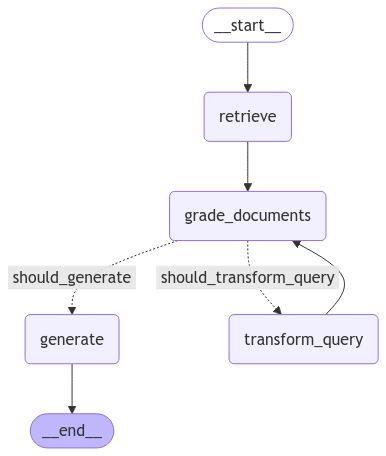

In [113]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass